In [285]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Literal

class SincConv(nn.Module):
    """Sinc-based convolution

    Parameters
    ----------
    in_channels : `int`
        Number of input channels. Must be 1.
    out_channels : `int`
        Number of filters.
    kernel_size : `int`
        Filter length.
    sample_rate : `int`, optional
        Sample rate. Defaults to 16000.

    Usage
    -----
    See `torch.nn.Conv1d`

    Reference
    ---------
    Mirco Ravanelli, Yoshua Bengio,
    "Speaker Recognition from raw waveform with SincNet".
    https://arxiv.org/abs/1808.00158

    """

    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)

    @staticmethod
    def get_general_cosine_window(n, params):
        # https://github.com/pytorch/pytorch/blob/main/torch/signal/windows/windows.py#L643
        constant = 2*math.pi / (n-1)
        device = params.device
        k = torch.linspace(0, (n-1)*constant, n, device=device)
        a_i = torch.tensor([(-1) ** i * w for i, w in enumerate(params)], dtype=torch.float, device=device)
        i = torch.arange(a_i.shape[0], device=device)
        return torch.tensor((a_i.unsqueeze(-1) * torch.cos(i.unsqueeze(-1) * k)).sum(0), dtype=torch.float, device=device)

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, bias=False, groups=1,
                 sample_rate=16000, min_low_hz=50, min_band_hz=2,
                 window_func: Literal['learnable', 'hamming', 'hanning', 'none']='learnable', 
                 window_k: Literal[2,3,4]=3):

        super().__init__()

        if in_channels != 1:
            msg = (f'SincConv only support one input channel '
                   f'(here, in_channels = {in_channels:d}).')
            raise ValueError(msg)

        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size%2==0:
            self.kernel_size = kernel_size+1
        else:
            self.kernel_size = kernel_size

        self.out_channels = out_channels
        self.window_func = window_func
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError(f'SincConv does not support bias.')
        if groups > 1:
            raise ValueError(f'SincConv does not support groups.')

        self.sample_rate = sample_rate
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz

        # initialize filterbanks such that they are equally spaced in Mel scale
        low_hz = min_low_hz
        high_hz = self.sample_rate / 2 - (self.min_low_hz + self.min_band_hz)

        mel = np.linspace(self.to_mel(low_hz),
                          self.to_mel(high_hz),
                          self.out_channels + 1)
        hz = self.to_hz(mel) / self.sample_rate

        # filter lower frequency (out_channels, 1)
        self.low_hz_ = nn.Parameter(torch.Tensor(hz[:-1]).view(-1, 1))

        # filter frequency band (out_channels, 1)
        self.band_hz_ = nn.Parameter(torch.Tensor(np.diff(hz)).view(-1, 1))

        # window
        if self.window_func == 'hamming':
            self.window_ = torch.hamming_window(self.kernel_size)
        elif self.window_func == 'hanning':
            self.window_ = torch.hanning_window(self.kernel_size)
        elif self.window_func == 'learnable':
            self.window_k = window_k
            self.window_params = nn.Parameter(torch.rand(window_k)) # TODO: constraint: sum(window_params)=1
            self.window_ = self.get_general_cosine_window(self.kernel_size, self.window_params)
        else: # 'none'
            self.window_ = torch.ones((self.kernel_size))

        # (kernel_size, 1)
        n = self.kernel_size / 2
        self.n_ = torch.arange(-n, n).view(1, -1) / self.sample_rate


    def forward(self, waveforms):
        """

        Parameters
        ----------
        waveforms : `torch.Tensor` (batch_size, 1, n_samples)
            Batch of waveforms.

        Returns
        -------
        features : `torch.Tensor` (batch_size, out_channels, n_samples_out)
            Batch of sinc filters activations.

        """

        self.n_ = self.n_.to(waveforms.device)
        if self.window_func == 'learnable':
            self.window_ = self.get_general_cosine_window(self.kernel_size, self.window_params)
        self.window_ = self.window_.to(waveforms.device)

        low = self.min_low_hz / self.sample_rate + torch.abs(self.low_hz_)
        high = low + self.min_band_hz /self.sample_rate + torch.abs(self.band_hz_)

        f_times_t = torch.matmul(low, self.n_)
        low_pass1 = 2 * low * torch.sinc(
            2 * math.pi * f_times_t * self.sample_rate)

        f_times_t = torch.matmul(high, self.n_)
        low_pass2 = 2 * high * torch.sinc(
            2 * math.pi * f_times_t * self.sample_rate)

        band_pass = low_pass2 - low_pass1
        max_, _ = torch.max(band_pass, dim=1, keepdim=True)
        band_pass = band_pass / max_

        filters = (band_pass * self.window_).view(
            self.out_channels, 1, self.kernel_size)
        
        self.filters = filters

        return F.conv1d(waveforms, filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                        bias=None, groups=1)

In [239]:
m = SincConv(in_channels=1, out_channels=3, kernel_size=65)

/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/2349055606.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a_i.unsqueeze(-1) * torch.cos(i.unsqueeze(-1) * k)).sum(0), dtype=torch.float, device=device)


In [240]:
x = torch.rand([512]).view(1,-1)

In [241]:
x

tensor([[0.3709, 0.8468, 0.4765, 0.8624, 0.2611, 0.9359, 0.0204, 0.3834, 0.8127,
         0.0888, 0.9804, 0.7037, 0.4460, 0.0083, 0.4983, 0.0440, 0.9133, 0.9838,
         0.9936, 0.6312, 0.7100, 0.8945, 0.1328, 0.3955, 0.3513, 0.8986, 0.8392,
         0.8488, 0.9337, 0.6605, 0.6906, 0.7925, 0.9195, 0.2548, 0.9666, 0.9960,
         0.7534, 0.2109, 0.4583, 0.8749, 0.4471, 0.5575, 0.7008, 0.8208, 0.1962,
         0.4784, 0.2674, 0.4950, 0.6871, 0.1390, 0.4400, 0.8994, 0.6455, 0.8898,
         0.1991, 0.2030, 0.2833, 0.0996, 0.1872, 0.6985, 0.6157, 0.4812, 0.1197,
         0.0018, 0.9056, 0.1500, 0.3340, 0.7132, 0.7497, 0.7657, 0.1140, 0.1151,
         0.7067, 0.3848, 0.9804, 0.7109, 0.7466, 0.7326, 0.0942, 0.1064, 0.9806,
         0.1532, 0.3659, 0.0556, 0.6523, 0.2881, 0.3019, 0.3309, 0.9103, 0.7280,
         0.1363, 0.7000, 0.2427, 0.0901, 0.5846, 0.1285, 0.2960, 0.0782, 0.0661,
         0.0479, 0.5367, 0.5316, 0.1512, 0.0574, 0.8593, 0.1063, 0.2854, 0.4185,
         0.4072, 0.6810, 0.3

In [242]:
m(x)

/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/2349055606.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a_i.unsqueeze(-1) * torch.cos(i.unsqueeze(-1) * k)).sum(0), dtype=torch.float, device=device)


tensor([[  1.1179,   1.4232,   1.6552,  ...,  -0.7986,  -0.1355,   0.6656],
        [ -1.0359,  -1.5442,   1.4364,  ...,   0.3747,  -1.3866,  -1.0881],
        [ -5.6256,  -5.5869, -11.2953,  ...,  -0.9863,  -0.1621,  -2.4847]],
       grad_fn=<SqueezeBackward1>)

In [244]:
m(x).size()

/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/2349055606.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a_i.unsqueeze(-1) * torch.cos(i.unsqueeze(-1) * k)).sum(0), dtype=torch.float, device=device)


torch.Size([3, 448])

In [245]:
n=(65)/2
torch.arange(-n, n).size()

torch.Size([65])

In [246]:
m

SincConv()

In [247]:
m.window_

tensor([-0.3549, -0.3571, -0.3633, -0.3731, -0.3855, -0.3992, -0.4126, -0.4241,
        -0.4317, -0.4336, -0.4280, -0.4132, -0.3877, -0.3503, -0.3004, -0.2374,
        -0.1614, -0.0731,  0.0266,  0.1361,  0.2536,  0.3768,  0.5030,  0.6295,
         0.7533,  0.8714,  0.9808,  1.0788,  1.1628,  1.2305,  1.2803,  1.3107,
         1.3209,  1.3107,  1.2803,  1.2305,  1.1628,  1.0788,  0.9808,  0.8714,
         0.7533,  0.6295,  0.5030,  0.3768,  0.2536,  0.1361,  0.0266, -0.0731,
        -0.1614, -0.2374, -0.3004, -0.3503, -0.3877, -0.4132, -0.4280, -0.4336,
        -0.4317, -0.4241, -0.4126, -0.3992, -0.3855, -0.3731, -0.3633, -0.3571,
        -0.3549])

In [251]:
m.filters.detach().numpy()

array([[[ 1.36208255e-03, -8.95624142e-03, -1.73937175e-02,
         -9.97384917e-03,  5.28970780e-03,  7.53948418e-03,
         -6.75224327e-03, -1.54316425e-02, -1.49315677e-03,
          1.91654544e-02,  1.85846221e-02, -4.70999017e-04,
         -6.94487384e-03,  1.04966201e-02,  2.56576166e-02,
          1.75427217e-02,  2.32587894e-03,  1.11511537e-04,
         -1.87922118e-03, -1.85298044e-02, -2.65905093e-02,
         -6.95203152e-03, -5.64199639e-03, -7.48321787e-02,
         -1.53181598e-01, -1.13310151e-01,  1.96377710e-02,
          1.84162445e-02, -2.35346496e-01, -4.55726296e-01,
         -1.84569806e-01,  6.06815040e-01,  1.32091868e+00,
          1.31069267e+00,  5.92740119e-01, -1.77396923e-01,
         -4.30626690e-01, -2.18347847e-01,  1.67435892e-02,
          1.74467731e-02, -9.79551673e-02, -1.28009349e-01,
         -5.97954430e-02, -4.22607129e-03, -4.67953552e-03,
         -1.42716998e-02, -3.61818145e-03,  5.16796019e-03,
          2.46251875e-04,  3.42010171e-0

In [231]:
import matplotlib.pyplot as plt

In [232]:
m

SincConv()

In [248]:
m.low_hz_

Parameter containing:
tensor([[0.0031],
        [0.0621],
        [0.1955]], requires_grad=True)

In [249]:
m.band_hz_

Parameter containing:
tensor([[0.0590],
        [0.1333],
        [0.3013]], requires_grad=True)

In [290]:
m.low_hz_*16000

tensor([[  50.0000],
        [ 994.3875],
        [3127.9319]], grad_fn=<MulBackward0>)

In [291]:
m.band_hz_*16000

tensor([[ 944.3875],
        [2133.5444],
        [4820.0679]], grad_fn=<MulBackward0>)

In [250]:
m.window_params

Parameter containing:
tensor([0.1608, 0.8379, 0.3222], requires_grad=True)

In [252]:
filters = m.filters.detach().numpy()
print(filters.shape)
filters = np.squeeze(filters)

(3, 1, 65)


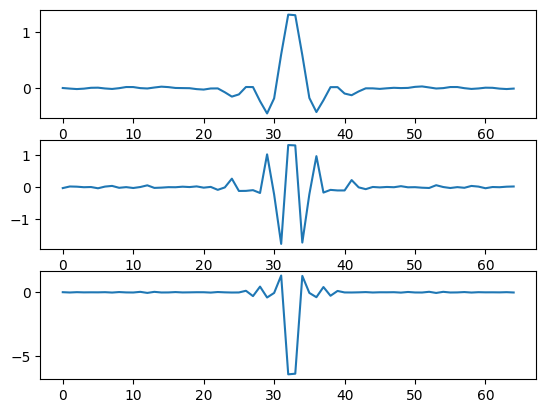

In [254]:
fig, axes = plt.subplots(filters.shape[0])
for i, ax in enumerate(axes):
    ax.plot(filters[i])

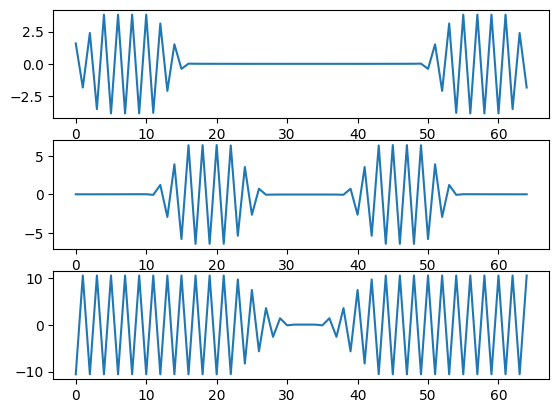

In [262]:
fig, axes = plt.subplots(filters.shape[0])
for i, ax in enumerate(axes):
    ax.plot(np.fft.fft(filters[i]))

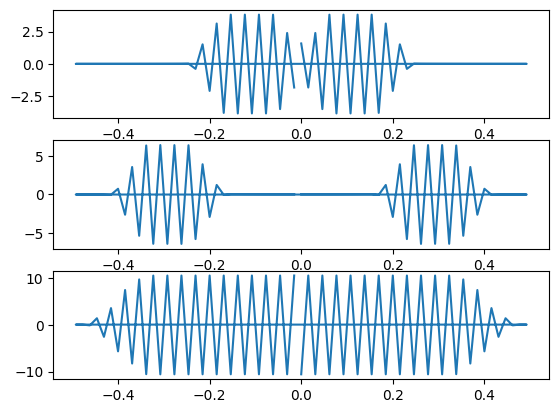

In [270]:
fig, axes = plt.subplots(filters.shape[0])
for i, ax in enumerate(axes):
    sp = np.fft.fft(filters[i])
    freq = np.fft.fftfreq(filters[i].shape[-1])
    ax.plot(freq, sp.real)

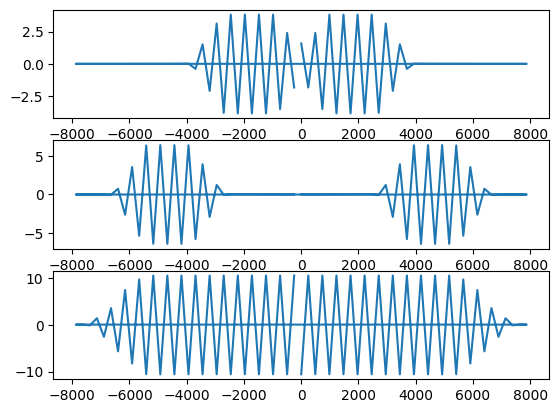

In [272]:
fig, axes = plt.subplots(filters.shape[0])
for i, ax in enumerate(axes):
    sp = np.fft.fft(filters[i])
    freq = np.fft.fftfreq(filters[i].shape[-1], d=1/16000)
    ax.plot(freq, sp.real)

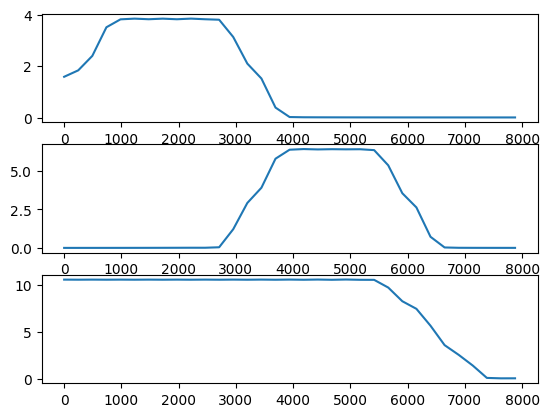

In [295]:
fig, axes = plt.subplots(filters.shape[0])
for i, ax in enumerate(axes):
    l = filters[i].shape[-1]
    sp = np.fft.fft(filters[i])
    freq = np.fft.fftfreq(l, d=1/16000)
    ax.plot(freq[:l//2+l%2], np.abs(sp.real[:l//2+l%2]))

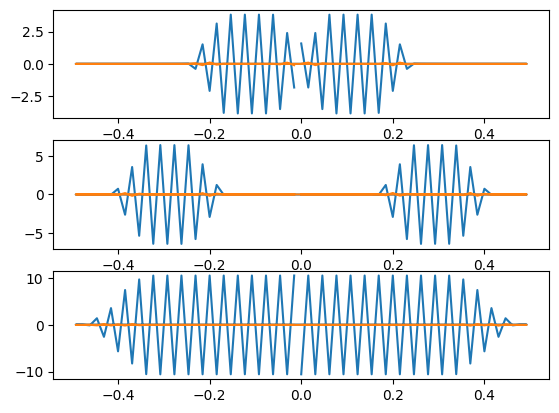

In [264]:
fig, axes = plt.subplots(filters.shape[0])
for i, ax in enumerate(axes):
    sp = np.fft.fft(filters[i])
    freq = np.fft.fftfreq(filters[i].shape[-1])
    ax.plot(freq, sp.real, freq, sp.imag)

In [265]:
freq

array([ 0.        ,  0.01538462,  0.03076923,  0.04615385,  0.06153846,
        0.07692308,  0.09230769,  0.10769231,  0.12307692,  0.13846154,
        0.15384615,  0.16923077,  0.18461538,  0.2       ,  0.21538462,
        0.23076923,  0.24615385,  0.26153846,  0.27692308,  0.29230769,
        0.30769231,  0.32307692,  0.33846154,  0.35384615,  0.36923077,
        0.38461538,  0.4       ,  0.41538462,  0.43076923,  0.44615385,
        0.46153846,  0.47692308,  0.49230769, -0.49230769, -0.47692308,
       -0.46153846, -0.44615385, -0.43076923, -0.41538462, -0.4       ,
       -0.38461538, -0.36923077, -0.35384615, -0.33846154, -0.32307692,
       -0.30769231, -0.29230769, -0.27692308, -0.26153846, -0.24615385,
       -0.23076923, -0.21538462, -0.2       , -0.18461538, -0.16923077,
       -0.15384615, -0.13846154, -0.12307692, -0.10769231, -0.09230769,
       -0.07692308, -0.06153846, -0.04615385, -0.03076923, -0.01538462])

In [266]:
freq.shape

(65,)

In [267]:
sp

array([-10.56062321+0.00000000e+00j,  10.55219754-2.85125396e-06j,
       -10.56066278-6.44522138e-06j,  10.55210844-9.59719862e-06j,
       -10.56078966-1.28823003e-05j,  10.55192823-1.67021551e-05j,
       -10.56102417-2.03871317e-05j,  10.55163796-2.50699516e-05j,
       -10.5613828 -2.95582665e-05j,  10.55120442-3.49230716e-05j,
       -10.56190351-4.12394754e-05j,  10.55058485-4.86889975e-05j,
       -10.56264217-5.75112258e-05j,  10.54969515-6.82503289e-05j,
       -10.56372204-8.20550480e-05j,  10.54838238-1.00396291e-04j,
       -10.5653321 -1.25170719e-04j,  10.54638603-1.60666465e-04j,
       -10.56782286-2.17139040e-04j,  10.54327017-3.15912084e-04j,
       -10.57149843-5.26042621e-04j,  10.54095275-1.17155838e-03j,
       -10.53599881-6.20925550e-03j,   9.71575328+7.10139450e-02j,
        -8.25956782-1.45484019e-01j,   7.45137497+1.37137017e-01j,
        -5.65367615-9.53294028e-02j,   3.58872027+1.20047332e-01j,
        -2.55394344-1.53105295e-01j,   1.41541259+1.01287736e-

In [268]:
sp.real

array([-10.56062321,  10.55219754, -10.56066278,  10.55210844,
       -10.56078966,  10.55192823, -10.56102417,  10.55163796,
       -10.5613828 ,  10.55120442, -10.56190351,  10.55058485,
       -10.56264217,  10.54969515, -10.56372204,  10.54838238,
       -10.5653321 ,  10.54638603, -10.56782286,  10.54327017,
       -10.57149843,  10.54095275, -10.53599881,   9.71575328,
        -8.25956782,   7.45137497,  -5.65367615,   3.58872027,
        -2.55394344,   1.41541259,  -0.10098293,   0.05545715,
         0.0585874 ,   0.0585874 ,   0.05545715,  -0.10098293,
         1.41541259,  -2.55394344,   3.58872027,  -5.65367615,
         7.45137497,  -8.25956782,   9.71575328, -10.53599881,
        10.54095275, -10.57149843,  10.54327017, -10.56782286,
        10.54638603, -10.5653321 ,  10.54838238, -10.56372204,
        10.54969515, -10.56264217,  10.55058485, -10.56190351,
        10.55120442, -10.5613828 ,  10.55163796, -10.56102417,
        10.55192823, -10.56078966,  10.55210844, -10.56

In [269]:
sp.imag

array([ 0.00000000e+00, -2.85125396e-06, -6.44522138e-06, -9.59719862e-06,
       -1.28823003e-05, -1.67021551e-05, -2.03871317e-05, -2.50699516e-05,
       -2.95582665e-05, -3.49230716e-05, -4.12394754e-05, -4.86889975e-05,
       -5.75112258e-05, -6.82503289e-05, -8.20550480e-05, -1.00396291e-04,
       -1.25170719e-04, -1.60666465e-04, -2.17139040e-04, -3.15912084e-04,
       -5.26042621e-04, -1.17155838e-03, -6.20925550e-03,  7.10139450e-02,
       -1.45484019e-01,  1.37137017e-01, -9.53294028e-02,  1.20047332e-01,
       -1.53105295e-01,  1.01287736e-01, -2.08942114e-02, -2.06265139e-03,
       -4.23946721e-04,  4.23946721e-04,  2.06265139e-03,  2.08942114e-02,
       -1.01287736e-01,  1.53105295e-01, -1.20047332e-01,  9.53294028e-02,
       -1.37137017e-01,  1.45484019e-01, -7.10139450e-02,  6.20925550e-03,
        1.17155838e-03,  5.26042621e-04,  3.15912084e-04,  2.17139040e-04,
        1.60666465e-04,  1.25170719e-04,  1.00396291e-04,  8.20550480e-05,
        6.82503289e-05,  

In [273]:
m2 = SincConv(in_channels=1, out_channels=3, kernel_size=65, window_func='hamming')

In [275]:
m2(x)

tensor([[ 0.3014,  0.4544,  0.6016,  ..., -1.1344, -0.5722, -0.0254],
        [-0.9075, -1.0949,  1.2241,  ...,  0.3956, -1.2441, -0.9028],
        [-4.1568, -4.3501, -8.4849,  ..., -0.7914, -0.1319, -1.7953]],
       grad_fn=<SqueezeBackward1>)

In [276]:
filters2 = m2.filters.detach().numpy()
print(filters2.shape)
filters2 = np.squeeze(filters2)

(3, 1, 65)


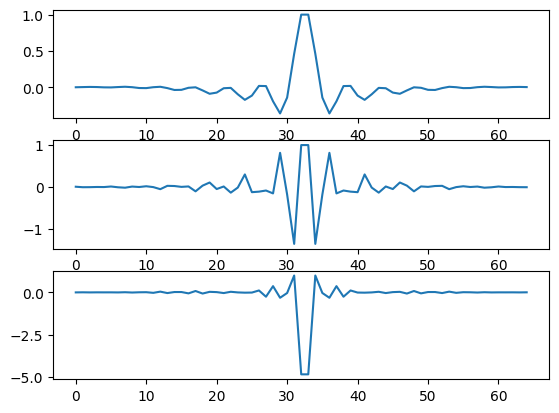

In [277]:
fig, axes = plt.subplots(filters2.shape[0])
for i, ax in enumerate(axes):
    ax.plot(filters2[i])

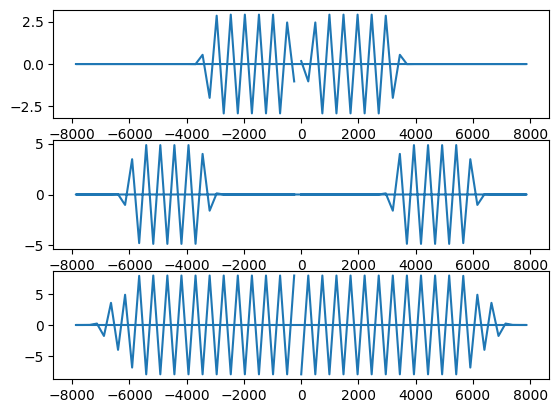

In [278]:
fig, axes = plt.subplots(filters2.shape[0])
for i, ax in enumerate(axes):
    sp = np.fft.fft(filters2[i])
    freq = np.fft.fftfreq(filters2[i].shape[-1], d=1/16000)
    ax.plot(freq, sp.real)

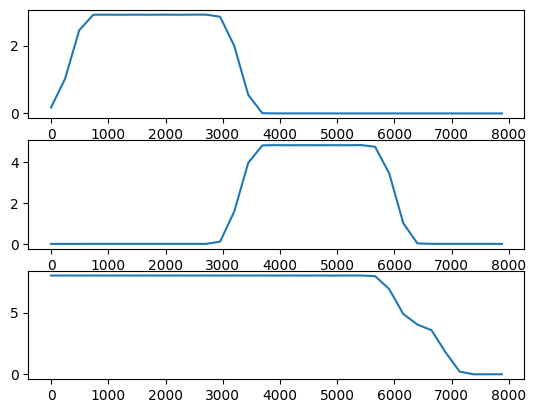

In [294]:
fig, axes = plt.subplots(filters2.shape[0])
for i, ax in enumerate(axes):
    l = filters2[i].shape[-1]
    sp = np.fft.fft(filters2[i])
    freq = np.fft.fftfreq(l, d=1/16000)
    ax.plot(freq[:l//2+l%2], np.abs(sp.real[:l//2+l%2]))

In [286]:
m3 = SincConv(in_channels=1, out_channels=3, kernel_size=65, window_func='none')
m3(x)

tensor([[ 0.0264,  0.1483,  0.2822,  ..., -1.4209, -0.8236, -0.2771],
        [-0.9677, -1.0915,  1.2969,  ...,  0.4640, -1.3592, -0.9556],
        [-4.0453, -4.4377, -8.4208,  ..., -0.7992, -0.1452, -1.7206]],
       grad_fn=<SqueezeBackward1>)

In [287]:
filters3 = m3.filters.detach().numpy()
print(filters3.shape)
filters3 = np.squeeze(filters3)

(3, 1, 65)


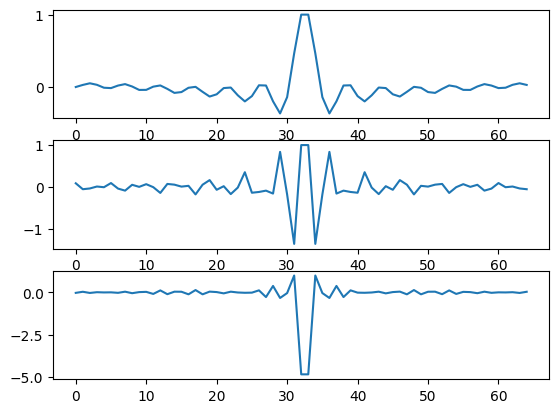

In [288]:
fig, axes = plt.subplots(filters3.shape[0])
for i, ax in enumerate(axes):
    ax.plot(filters3[i])

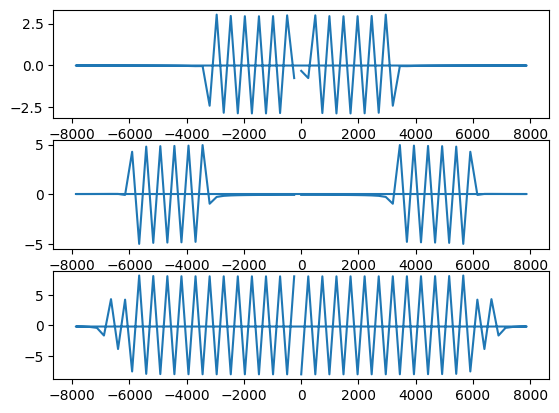

In [289]:
fig, axes = plt.subplots(filters3.shape[0])
for i, ax in enumerate(axes):
    sp = np.fft.fft(filters3[i])
    freq = np.fft.fftfreq(filters3[i].shape[-1], d=1/16000)
    ax.plot(freq, sp.real)

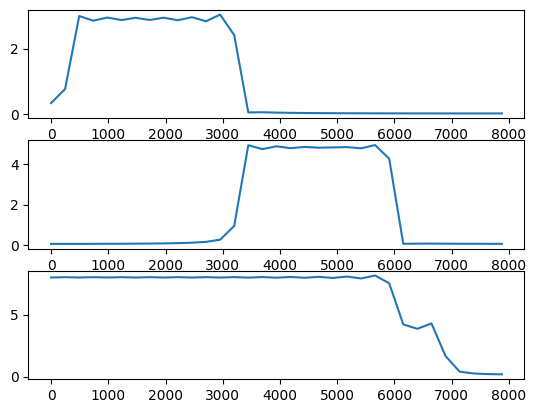

In [293]:
fig, axes = plt.subplots(filters3.shape[0])
for i, ax in enumerate(axes):
    l = filters3[i].shape[-1]
    sp = np.fft.fft(filters3[i])
    freq = np.fft.fftfreq(l, d=1/16000)
    ax.plot(freq[:l//2+l%2], np.abs(sp.real[:l//2+l%2]))

In [296]:
import geotorch

In [304]:
m4 = SincConv(in_channels=1, out_channels=3, kernel_size=65, window_func='learnable')
geotorch.sphere(m4, "window_params")

/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/774782132.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a_i.unsqueeze(-1) * torch.cos(i.unsqueeze(-1) * k)).sum(0), dtype=torch.float, device=device)


ParametrizedSincConv(
  (parametrizations): ModuleDict(
    (window_params): ParametrizationList(
      (0): Sphere(n=3, radius=1.0)
    )
  )
)

In [305]:
m4(x)

/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/774782132.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a_i.unsqueeze(-1) * torch.cos(i.unsqueeze(-1) * k)).sum(0), dtype=torch.float, device=device)


tensor([[ 1.7873,  2.1834,  2.4091,  ...,  0.3571,  0.7205,  1.4615],
        [-0.5172, -1.2979,  0.7530,  ...,  0.0901, -0.6777, -0.6505],
        [-3.9827, -3.8358, -8.0256,  ..., -0.6143, -0.0851, -1.8618]],
       grad_fn=<SqueezeBackward1>)

In [306]:
m4.window_params

tensor([-0.0643, -0.0014,  0.9979], grad_fn=<MulBackward0>)

In [313]:
p = m4.window_params.detach().numpy()
p -= p.min()
p /= p.max()
p

array([0.       , 0.0592348, 1.       ], dtype=float32)

In [336]:
class NormWeight(torch.nn.Module):
    def forward(self, X):
        X = X - X.min()
        X = X/(X.max() - X.min())
        return X

In [323]:
import torch.nn.utils.parametrize as parametrize

In [337]:
m5 = SincConv(in_channels=1, out_channels=3, kernel_size=65, window_func='learnable')
geotorch.sphere(m5, "window_params")
parametrize.register_parametrization(m5, "window_params", NormWeight())

/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/774782132.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a_i.unsqueeze(-1) * torch.cos(i.unsqueeze(-1) * k)).sum(0), dtype=torch.float, device=device)


ParametrizedSincConv(
  (parametrizations): ModuleDict(
    (window_params): ParametrizationList(
      (0): Sphere(n=3, radius=1.0)
      (1): NormWeight()
    )
  )
)

In [338]:
m5(x)

/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/774782132.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a_i.unsqueeze(-1) * torch.cos(i.unsqueeze(-1) * k)).sum(0), dtype=torch.float, device=device)


tensor([[  0.6445,   0.8535,   1.0404,  ...,  -1.0596,  -0.4215,   0.2369],
        [ -1.0158,  -1.3187,   1.3956,  ...,   0.4023,  -1.3639,  -1.0269],
        [ -5.0897,  -5.0918, -10.2018,  ...,  -0.9227,  -0.1574,  -2.2099]],
       grad_fn=<SqueezeBackward1>)

In [339]:
m5.window_params

tensor([0.1952, 1.0000, 0.0000], grad_fn=<DivBackward0>)

In [340]:
m5(x)
m5.window_params

/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/774782132.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a_i.unsqueeze(-1) * torch.cos(i.unsqueeze(-1) * k)).sum(0), dtype=torch.float, device=device)


tensor([0.1952, 1.0000, 0.0000], grad_fn=<DivBackward0>)

In [341]:
class PositiveWeight(torch.nn.Module):
    def forward(self, X):
        X = X.abs()
        return X

In [342]:
m6 = SincConv(in_channels=1, out_channels=3, kernel_size=65, window_func='learnable')
parametrize.register_parametrization(m6, "window_params", PositiveWeight())

/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/774782132.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a_i.unsqueeze(-1) * torch.cos(i.unsqueeze(-1) * k)).sum(0), dtype=torch.float, device=device)


ParametrizedSincConv(
  (parametrizations): ModuleDict(
    (window_params): ParametrizationList(
      (0): PositiveWeight()
    )
  )
)

In [343]:
m6(x)

/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/774782132.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a_i.unsqueeze(-1) * torch.cos(i.unsqueeze(-1) * k)).sum(0), dtype=torch.float, device=device)


tensor([[  2.1070,   2.6462,   3.0220,  ...,  -0.8099,   0.1420,   1.4274],
        [ -1.4651,  -2.4163,   2.0456,  ...,   0.4911,  -1.9590,  -1.5870],
        [ -8.4394,  -8.3561, -16.9834,  ...,  -1.4453,  -0.2308,  -3.7730]],
       grad_fn=<SqueezeBackward1>)

In [344]:
m6.window_params

tensor([0.2246, 0.9139, 0.8456], grad_fn=<AbsBackward0>)

In [349]:
class SoftmaxWeight(torch.nn.Module):
    def forward(self, X):
        X = torch.nn.functional.softmax(X)
        return X

In [437]:
class PreluWeight(torch.nn.Module):
    def forward(self, X, a=0.2):
        a = torch.tensor(a)
        X = torch.nn.functional.prelu(X, a)
        return X

In [350]:
m6 = SincConv(in_channels=1, out_channels=3, kernel_size=65, window_func='learnable')
geotorch.sphere(m6, "window_params")
parametrize.register_parametrization(m6, "window_params", SoftmaxWeight())

/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/774782132.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a_i.unsqueeze(-1) * torch.cos(i.unsqueeze(-1) * k)).sum(0), dtype=torch.float, device=device)
/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/2739842355.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = torch.nn.functional.softmax(X)


ParametrizedSincConv(
  (parametrizations): ModuleDict(
    (window_params): ParametrizationList(
      (0): Sphere(n=3, radius=1.0)
      (1): SoftmaxWeight()
    )
  )
)

In [351]:
m6(x)
m6.window_params

/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/2739842355.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = torch.nn.functional.softmax(X)
/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/774782132.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a_i.unsqueeze(-1) * torch.cos(i.unsqueeze(-1) * k)).sum(0), dtype=torch.float, device=device)


tensor([0.2518, 0.5899, 0.1584], grad_fn=<SoftmaxBackward0>)

In [352]:
m7 = SincConv(in_channels=1, out_channels=3, kernel_size=65, window_func='learnable')
parametrize.register_parametrization(m7, "window_params", SoftmaxWeight())

/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/774782132.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a_i.unsqueeze(-1) * torch.cos(i.unsqueeze(-1) * k)).sum(0), dtype=torch.float, device=device)
/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/2739842355.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = torch.nn.functional.softmax(X)


ParametrizedSincConv(
  (parametrizations): ModuleDict(
    (window_params): ParametrizationList(
      (0): SoftmaxWeight()
    )
  )
)

In [353]:
m7(x)
m7.window_params

/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/2739842355.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = torch.nn.functional.softmax(X)
/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/774782132.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a_i.unsqueeze(-1) * torch.cos(i.unsqueeze(-1) * k)).sum(0), dtype=torch.float, device=device)


tensor([0.5397, 0.2470, 0.2133], grad_fn=<SoftmaxBackward0>)

In [355]:
test_inputs = torch.randn(33, 16, 30)
test_filters = torch.randn(20, 16, 5)
test_result = F.conv1d(test_inputs, test_filters)
test_result.size()

torch.Size([33, 20, 26])

In [425]:
class WSincConv(nn.Module):
    """Sinc-based convolution

    Parameters
    ----------
    in_channels : `int`
        Number of input channels.
    out_channels : `int`
        Number of filters.
    kernel_size : `int`
        Filter length.
    sample_rate : `int`, optional
        Sample rate. Defaults to 16000.

    Usage
    -----
    See `torch.nn.Conv1d`

    Reference
    ---------
    Mirco Ravanelli, Yoshua Bengio,
    "Speaker Recognition from raw waveform with SincNet".
    https://arxiv.org/abs/1808.00158

    """

    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)

    @staticmethod
    def get_general_cosine_window(n, params):
        # https://github.com/pytorch/pytorch/blob/main/torch/signal/windows/windows.py#L643
        constant = 2*math.pi / (n-1)
        device = params.device
        k = torch.linspace(0, (n-1)*constant, n, device=device)
        a_i = torch.tensor([(-1) ** i * w for i, w in enumerate(params)], dtype=torch.float, device=device)
        i = torch.arange(a_i.shape[0], device=device)
        return torch.tensor((a_i.unsqueeze(-1) * torch.cos(i.unsqueeze(-1) * k)).sum(0), dtype=torch.float, device=device)

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, bias=False, groups=1,
                 sample_rate=16000, min_low_hz=50, min_band_hz=2,
                 window_func: Literal['learnable', 'hamming', 'hanning', 'none']='learnable', 
                 window_k: Literal[2,3,4]=3):

        super().__init__()

        self.in_channels = in_channels

        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size%2==0:
            self.kernel_size = kernel_size+1
        else:
            self.kernel_size = kernel_size

        self.out_channels = out_channels
        self.window_func = window_func
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError(f'SincConv does not support bias.')
        if groups > 1:
            raise ValueError(f'SincConv does not support groups.')

        self.sample_rate = sample_rate
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz

        # initialize filterbanks such that they are equally spaced in Mel scale
        low_hz = min_low_hz
        high_hz = self.sample_rate / 2 - (self.min_low_hz + self.min_band_hz)

        mel = np.linspace(self.to_mel(low_hz),
                          self.to_mel(high_hz),
                          self.out_channels + 1)
        hz = self.to_hz(mel) / self.sample_rate

        # filter lower frequency (out_channels, in_channels)
        low_hz_ = torch.Tensor(hz[:-1]).repeat(in_channels, 1).view(
                                                  out_channels,in_channels,1)
        self.low_hz_ = nn.Parameter(low_hz_)
        print(self.low_hz_.size())

        # filter frequency band (out_channels, in_channels)
        band_hz_ = torch.Tensor(np.diff(hz)).repeat(in_channels, 1).view(
                                                    out_channels,in_channels,1)
        self.band_hz_ = nn.Parameter(band_hz_)
        print(self.band_hz_.size())

        # window
        if self.window_func == 'hamming':
            self.window_ = torch.hamming_window(self.kernel_size)
        elif self.window_func == 'hanning':
            self.window_ = torch.hanning_window(self.kernel_size)
        elif self.window_func == 'learnable': # for each channel?
            self.window_k = window_k
            self.window_params = nn.Parameter(torch.rand(window_k)) 
            self.window_ = self.get_general_cosine_window(self.kernel_size, self.window_params)
        else: # 'none'
            self.window_ = torch.ones((self.kernel_size))

        # (kernel_size, in_channels)
        # I think it should be inp, ker => trying this
        n = self.kernel_size / 2
        self.n_ = torch.arange(-n, n).repeat(in_channels,1) / self.sample_rate

    def forward(self, waveforms):
        """

        Parameters
        ----------
        waveforms : `torch.Tensor` (batch_size, 1, n_samples)
            Batch of waveforms.

        Returns
        -------
        features : `torch.Tensor` (batch_size, out_channels, n_samples_out)
            Batch of sinc filters activations.

        """

        self.n_ = self.n_.to(waveforms.device)
        if self.window_func == 'learnable':
            self.window_ = self.get_general_cosine_window(self.kernel_size, self.window_params)
        self.window_ = self.window_.to(waveforms.device)

        # TODO: reimplement this
        low = self.min_low_hz / self.sample_rate + torch.abs(self.low_hz_)
        high = low + self.min_band_hz /self.sample_rate + torch.abs(self.band_hz_)

        # (out, inp, 1) * (1, inp, ker) => (out, inp, ker)
        f_times_t = low * self.n_
        print(f_times_t.size())
        # (out, inp, inp) * (out, inp, ker)
        low_pass1 = 2 * low * torch.sinc(
            2 * math.pi * f_times_t * self.sample_rate)
        
        f_times_t = high * self.n_
        low_pass2 = 2 * high * torch.sinc(
            2 * math.pi * f_times_t * self.sample_rate)

        band_pass = low_pass2 - low_pass1
        max_, _ = torch.max(band_pass, dim=2, keepdim=True)
        band_pass = band_pass / max_
        
        # (out, inp, ker) * (ker) => (out, inp, ker)
        filters = (band_pass * self.window_) #.view(self.out_channels, self.in_channels, self.kernel_size)
        print(filters.size())
        
        self.filters = filters

        return F.conv1d(waveforms, filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                        bias=None, groups=1)

In [426]:
mm = WSincConv(in_channels=2, out_channels=3, kernel_size=65, window_func='learnable')

torch.Size([3, 2, 1])
torch.Size([3, 2, 1])


/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/1086505744.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a_i.unsqueeze(-1) * torch.cos(i.unsqueeze(-1) * k)).sum(0), dtype=torch.float, device=device)


In [427]:
xx = x.repeat(2,1)
xx.size()


torch.Size([2, 512])

In [428]:
mm(xx)

torch.Size([3, 2, 65])
torch.Size([3, 2, 65])


/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/1086505744.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a_i.unsqueeze(-1) * torch.cos(i.unsqueeze(-1) * k)).sum(0), dtype=torch.float, device=device)


tensor([[ 0.2806,  0.0454,  3.0092,  ..., -0.2653, -1.2244, -0.1985],
        [-3.9294, -3.6119, -8.6124,  ..., -1.4732, -0.1371, -1.4989],
        [-6.0392, -6.5919, -9.0784,  ..., -0.5676, -1.3740, -3.2678]],
       grad_fn=<SqueezeBackward1>)

In [432]:
mm1 = WSincConv(in_channels=2, out_channels=7, 
                kernel_size=256, window_func='learnable', window_k=10)
geotorch.sphere(mm1, "window_params")
# parametrize.register_parametrization(mm1, "window_params", SoftmaxWeight())
print(mm1(xx).size())
mm1.window_params

torch.Size([7, 2, 1])
torch.Size([7, 2, 1])
torch.Size([7, 2, 257])
torch.Size([7, 2, 257])
torch.Size([7, 256])


/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/1086505744.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a_i.unsqueeze(-1) * torch.cos(i.unsqueeze(-1) * k)).sum(0), dtype=torch.float, device=device)


tensor([ 0.0425, -0.8820,  0.2831, -0.1264,  0.0662, -0.0560, -0.1780,  0.0236,
        -0.2804, -0.0754], grad_fn=<MulBackward0>)

In [433]:
mm1 = WSincConv(in_channels=2, out_channels=7, 
                kernel_size=256, window_func='learnable', window_k=10)
# geotorch.sphere(mm1, "window_params")
parametrize.register_parametrization(mm1, "window_params", SoftmaxWeight())
print(mm1(xx).size())
mm1.window_params

torch.Size([7, 2, 1])
torch.Size([7, 2, 1])
torch.Size([7, 2, 257])
torch.Size([7, 2, 257])
torch.Size([7, 256])


/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/1086505744.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a_i.unsqueeze(-1) * torch.cos(i.unsqueeze(-1) * k)).sum(0), dtype=torch.float, device=device)
/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/2739842355.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = torch.nn.functional.softmax(X)


tensor([0.1066, 0.1391, 0.1097, 0.0668, 0.0816, 0.0727, 0.0993, 0.0774, 0.1457,
        0.1012], grad_fn=<SoftmaxBackward0>)

In [434]:
mm1 = WSincConv(in_channels=2, out_channels=7, 
                kernel_size=256, window_func='learnable', window_k=10)
geotorch.sphere(mm1, "window_params")
parametrize.register_parametrization(mm1, "window_params", SoftmaxWeight())
print(mm1(xx).size())
mm1.window_params

torch.Size([7, 2, 1])
torch.Size([7, 2, 1])
torch.Size([7, 2, 257])
torch.Size([7, 2, 257])
torch.Size([7, 256])


/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/1086505744.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a_i.unsqueeze(-1) * torch.cos(i.unsqueeze(-1) * k)).sum(0), dtype=torch.float, device=device)
/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/2739842355.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = torch.nn.functional.softmax(X)


tensor([0.1206, 0.0720, 0.1239, 0.1398, 0.0707, 0.0584, 0.1293, 0.0783, 0.0728,
        0.1342], grad_fn=<SoftmaxBackward0>)

In [448]:
mm1 = WSincConv(in_channels=2, out_channels=7, 
                kernel_size=256, window_func='learnable', window_k=10)
parametrize.register_parametrization(mm1, "window_params", PreluWeight())
print(mm1(xx).size())
mm1.window_params

torch.Size([7, 2, 1])
torch.Size([7, 2, 1])
torch.Size([7, 2, 257])
torch.Size([7, 2, 257])
torch.Size([7, 256])


/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/1086505744.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a_i.unsqueeze(-1) * torch.cos(i.unsqueeze(-1) * k)).sum(0), dtype=torch.float, device=device)


tensor([0.9761, 0.3365, 0.8282, 0.3597, 0.4814, 0.4355, 0.2433, 0.8034, 0.7903,
        0.3132], grad_fn=<PreluKernelBackward0>)

In [456]:
mm1 = WSincConv(in_channels=2, out_channels=7, 
                kernel_size=256, window_func='learnable', window_k=5)
geotorch.sphere(mm1, "window_params")
parametrize.register_parametrization(mm1, "window_params", PreluWeight())
print(mm1(xx).size())
mm1.window_params

torch.Size([7, 2, 1])
torch.Size([7, 2, 1])
torch.Size([7, 2, 257])
torch.Size([7, 2, 257])
torch.Size([7, 256])


/var/folders/q_/ct58044n3cl5m_35j6c0mwfm0000gn/T/ipykernel_35677/1086505744.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a_i.unsqueeze(-1) * torch.cos(i.unsqueeze(-1) * k)).sum(0), dtype=torch.float, device=device)


tensor([ 0.0220, -0.0362,  0.7335, -0.0592,  0.5840],
       grad_fn=<PreluKernelBackward0>)

In [370]:
t1 = torch.tensor([[2,3,7,1,1]])
t2 = torch.tensor([1,5,0,4,6])
t1*t2

tensor([[ 2, 15,  0,  4,  6]])

In [364]:
t2.repeat(3,2).size()

torch.Size([3, 10])

In [385]:
t3 = torch.tensor([2,3,7,1,1]).repeat(3,1)
print(t3)
t3*t2

tensor([[2, 3, 7, 1, 1],
        [2, 3, 7, 1, 1],
        [2, 3, 7, 1, 1]])


tensor([[ 2, 15,  0,  4,  6],
        [ 2, 15,  0,  4,  6],
        [ 2, 15,  0,  4,  6]])

In [386]:
t3.size()

torch.Size([3, 5])

In [377]:
torch.sinc(t3)

tensor([[ 2.7828e-08, -2.5305e-09, -6.0352e-08, -2.7828e-08, -2.7828e-08],
        [ 2.7828e-08, -2.5305e-09, -6.0352e-08, -2.7828e-08, -2.7828e-08],
        [ 2.7828e-08, -2.5305e-09, -6.0352e-08, -2.7828e-08, -2.7828e-08],
        [ 2.7828e-08, -2.5305e-09, -6.0352e-08, -2.7828e-08, -2.7828e-08],
        [ 2.7828e-08, -2.5305e-09, -6.0352e-08, -2.7828e-08, -2.7828e-08]])

In [397]:
tt1 = torch.rand([3,2,1])
tt2 = torch.rand([3,2,65])
tt3 = tt1*tt2
tt3.size()

torch.Size([3, 2, 65])

In [398]:
tt4 = torch.rand(65)

In [400]:
tt5 = tt2*tt4
tt5.size()

torch.Size([3, 2, 65])

In [405]:
tt11 = torch.rand([3,2,1])
tt22 = torch.rand([1,2,65])
tt33 = tt11*tt22
tt33.size()

torch.Size([3, 2, 65])

In [408]:
tt11 = torch.rand([3,2]).unsqueeze(-1)
tt22 = torch.rand([1,2,65])
tt33 = tt11*tt22
tt33.size()

torch.Size([3, 2, 65])

In [429]:
torch.max(tt33, dim=2, keepdim=True)

torch.return_types.max(
values=tensor([[[0.7879],
         [0.5478]],

        [[0.5468],
         [0.2405]],

        [[0.1102],
         [0.3467]]]),
indices=tensor([[[ 9],
         [56]],

        [[ 9],
         [56]],

        [[ 9],
         [56]]]))

In [458]:
from vector_quantize_pytorch import ResidualVQ

In [461]:
residual_vq = ResidualVQ(
    dim = 256,
    num_quantizers = 8,      # specify number of quantizers
    codebook_size = 1024,    # codebook size
)

xxx = torch.randn(1, 16000, 256)

quantized, indices, commit_loss = residual_vq(xxx)
print(quantized.size())
print(indices.size())

torch.Size([1, 16000, 256])
torch.Size([1, 16000, 8])


In [462]:
math.gcd(16000,4000)

4000